In [23]:
import numpy as np
from sklearn.model_selection import train_test_split

# Load from CSV; There are 160 samples in total
X = np.loadtxt('ns_out.csv', delimiter=',')   # shape (20, 160)
Y_real = np.loadtxt('rho_out_real.csv', delimiter=',')     # shape (2401, 160)
Y_imag = np.loadtxt('rho_out_imag.csv', delimiter=',')     # shape (2401, 160)

# Transpose to get shape (160, 20) and (160, 2401)
X = X.T
Y_real = Y_real.T
Y_imag = Y_imag.T

# split the data
#X_train, X_test, y_train, y_test = train_test_split(features, target_real, test_size=0.25, random_state=42)

X_train, X_test, Y_real_train, Y_real_test, Y_imag_train, Y_imag_test = train_test_split(
    X, Y_real, Y_imag, test_size=0.25)

# Optional: print shapes
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("Y_real_train:", Y_real_train.shape)
print("Y_real_test:", Y_real_test.shape)
print("Y_imag_train:", Y_imag_train.shape)
print("Y_imag_test:", Y_imag_test.shape)


X_train: (120, 20)
X_test: (40, 20)
Y_real_train: (120, 2401)
Y_real_test: (40, 2401)
Y_imag_train: (120, 2401)
Y_imag_test: (40, 2401)


In [35]:
#Here we introduce two models, one for the real part and one for the imaginary part
import tensorflow as tf
from tensorflow.keras import layers, Sequential

input_dim = np.shape(X_train)[1]
output_dim = np.shape(Y_real_train)[1]

#-----------------model_real
model_real = Sequential()
model_real.add(layers.Dense(64, activation='linear', input_shape=(input_dim,)))
#model_real.add(layers.Dense(128, activation='relu'))
model_real.add(layers.Dense(output_dim))

from tensorflow.keras.optimizers import Adam
learning_rate = 0.001 
adam = Adam(learning_rate=learning_rate)

model_real.compile(optimizer=adam, loss='mse')

#--------------------model_imag
model_imag = Sequential()
model_imag.add(layers.Dense(64, activation='linear', input_shape=(input_dim,)))
#model_imag.add(layers.Dense(128, activation='relu'))
model_imag.add(layers.Dense(output_dim))

model_imag.compile(optimizer='adam', loss='mse')

In [36]:
history_real=model_real.fit(X_train, Y_real_train, epochs=500, batch_size=100, validation_split=0.2)
history_imag=model_imag.fit(X_train, Y_imag_train, epochs=500, batch_size=100, validation_split=0.2)

Epoch 1/500
1/1 [==============================] - 0s 299ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 2/500
1/1 [==============================] - 0s 20ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 3/500
1/1 [==============================] - 0s 22ms/step - loss: 9.6121e-04 - val_loss: 0.0011
Epoch 4/500
1/1 [==============================] - 0s 22ms/step - loss: 7.4964e-04 - val_loss: 8.4620e-04
Epoch 5/500
1/1 [==============================] - 0s 23ms/step - loss: 5.9560e-04 - val_loss: 6.6406e-04
Epoch 6/500
1/1 [==============================] - 0s 24ms/step - loss: 4.8849e-04 - val_loss: 5.4000e-04
Epoch 7/500
1/1 [==============================] - 0s 24ms/step - loss: 4.1737e-04 - val_loss: 4.5899e-04
Epoch 8/500
1/1 [==============================] - 0s 23ms/step - loss: 3.7250e-04 - val_loss: 4.0859e-04
Epoch 9/500
1/1 [==============================] - 0s 22ms/step - loss: 3.4592e-04 - val_loss: 3.7897e-04
Epoch 10/500
1/1 [==============================] - 0s 24ms/step 

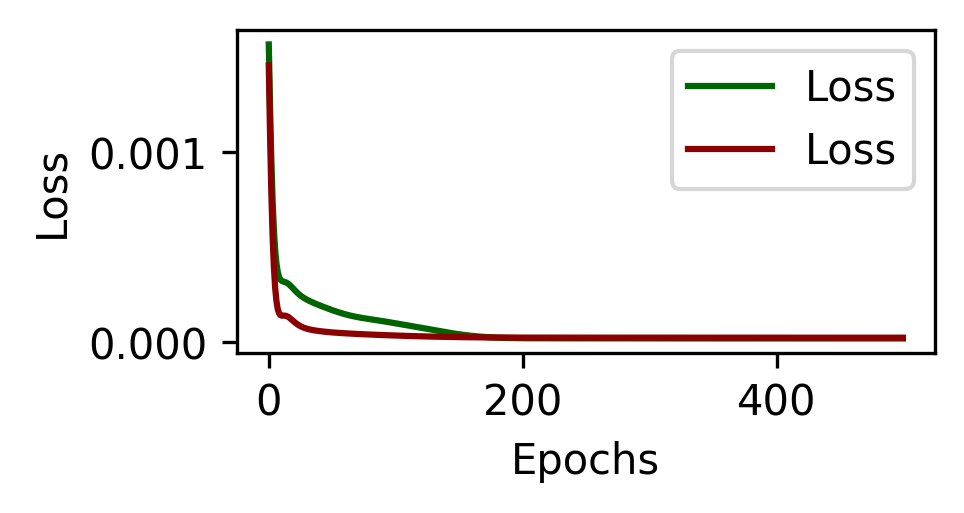

In [37]:
fig,ax = plt.subplots(1,1, figsize=(3,1.4),dpi=300)
plt.plot((history_real.history['loss']), label='Loss',c='Darkgreen')
plt.plot((history_imag.history['loss']), label='Loss',c='Darkred')
#plt.yscale("log")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [39]:
#-----------------predition of the models and output rho_pred
Y_real_pred = model_real.predict(X_test)
Y_imag_pred = model_imag.predict(X_test)
rho_pred_vector = Y_real_pred + 1j * Y_imag_pred

2/2 [==============================] - 0s 2ms/step


Average Fidelity: 0.9074141872610548938


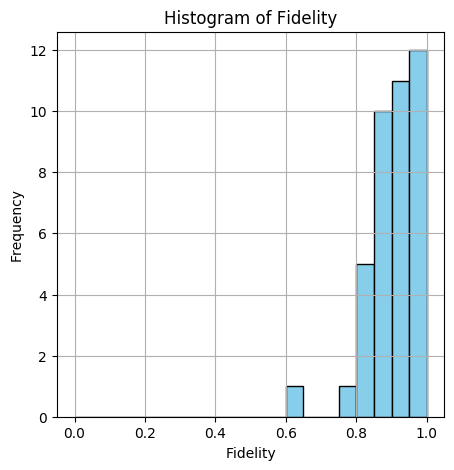

In [43]:
#------------------------Fiedelity
#we reshape the rho_pred_vector to matrix
rho_pred = rho_pred_vector.reshape(-1, 49, 49) #this is in the form of (40,49,49)
#print("shape of rho_pred_out:", rho_pred.shape)
#we do the same using the test data and reshape them into a matrix
rho_test_vector=Y_real_test+1j* Y_imag_test
rho_test=rho_test_vector.reshape(-1, 49, 49)

#for each matrix we calculate the fidelity
from scipy.linalg import sqrtm

Fid = []#fidelity of mixed states
n_samples=np.shape(rho_test)[0]

for i in range(n_samples):
    rho = rho_test[i]
    sigma = rho_pred[i]

    sigma = sigma / np.trace(sigma)
    
    sqrt_rho = sqrtm(rho)

    # Compute the product sqrt(rho) * sigma * sqrt(rho)
    inner = sqrt_rho @ sigma @ sqrt_rho

    # Take sqrt of that product
    sqrt_inner = sqrtm(inner)

    # Fidelity is the square of the trace of the above
    ff = np.real(np.trace(sqrt_inner))**2


    #fidelity = min(max(ff, 0.0), 1.0)

    Fid.append(ff)

Fid_array = np.array(Fid)
print("Average Fidelity:", np.mean(Fid_array))


import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.hist(Fid_array, bins=20, range=(0, 1), color='skyblue', edgecolor='black')
plt.xlabel('Fidelity')
plt.ylabel('Frequency')
plt.title('Histogram of Fidelity')
plt.grid(True)
plt.show()

Text(0, 0.5, 'g2_pred')

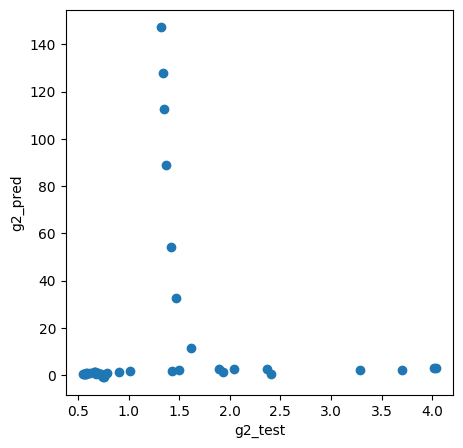

In [41]:
#------------------calculating g2 using rho_pred and rho_test can compare them to each other
from scipy.sparse import eye as speye, diags, kron
from scipy.sparse import csc_matrix

# Parameters
Na1 = 6
Na2 = 6
dima1 = Na1 + 1
dima2 = Na2 + 1
dimtot = dima1 * dima2

# Identity matrices
Ia1 = speye(dima1, format='csc')  
Ia2 = speye(dima2, format='csc')  
Itot = speye(dimtot, format='csc') 

# Creation operators (a†)
a1 = diags(np.sqrt(np.arange(1, dima1)), offsets=1, shape=(dima1, dima1), format='csc')
a2 = diags(np.sqrt(np.arange(1, dima2)), offsets=1, shape=(dima2, dima2), format='csc')

# Lift to full Hilbert space
a1 = kron(a1, Ia2, format='csc')
a2 = kron(Ia1, a2, format='csc')

g2_a1_test=[]
g2_a1_pred=[]

for i in range(n_samples):
    rho = rho_test[i]
    rho = rho / np.trace(rho)
    numerator = (a1.getH() @ a1 @ a1.getH() @ a1 - a1.getH() @ a1) @ rho
    denominator = (a1.getH() @ a1 @ rho).diagonal().sum() 
    g2_a1_test.append(numerator.diagonal().sum() / (denominator ** 2))

    del rho
    rho = rho_pred[i]
    numerator = (a1.getH() @ a1 @ a1.getH() @ a1 - a1.getH() @ a1) @ rho
    denominator = (a1.getH() @ a1 @ rho).diagonal().sum() 
    g2_a1_pred.append (numerator.diagonal().sum() / (denominator ** 2))

plt.figure(figsize=(5, 5))
plt.plot( np.array(g2_a1_test), np.array(g2_a1_pred),'o')
plt.xlabel('g2_test')
plt.ylabel('g2_pred')

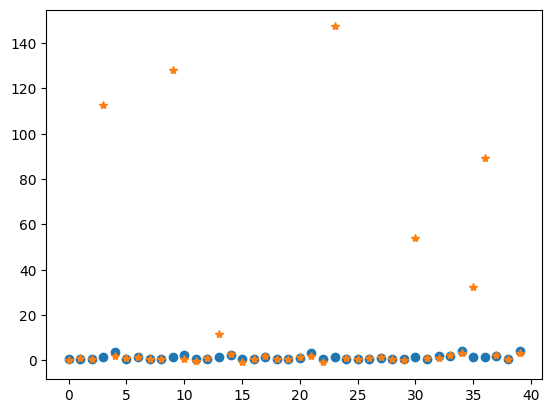

In [42]:
plt.plot(np.array(g2_a1_test),'o')
plt.plot(np.array(g2_a1_pred),'*')